Model is not converging.  Current: -308065.28527851054 is not greater than -51949.46199603652. Delta is -256115.823282474


Train shapes: (22042, 60, 11)
Test shapes: (22042, 10)
689/689 [==============================] - 81s 114ms/step
RMSE: 11.071211022197733, MSE: 122.5717134980326


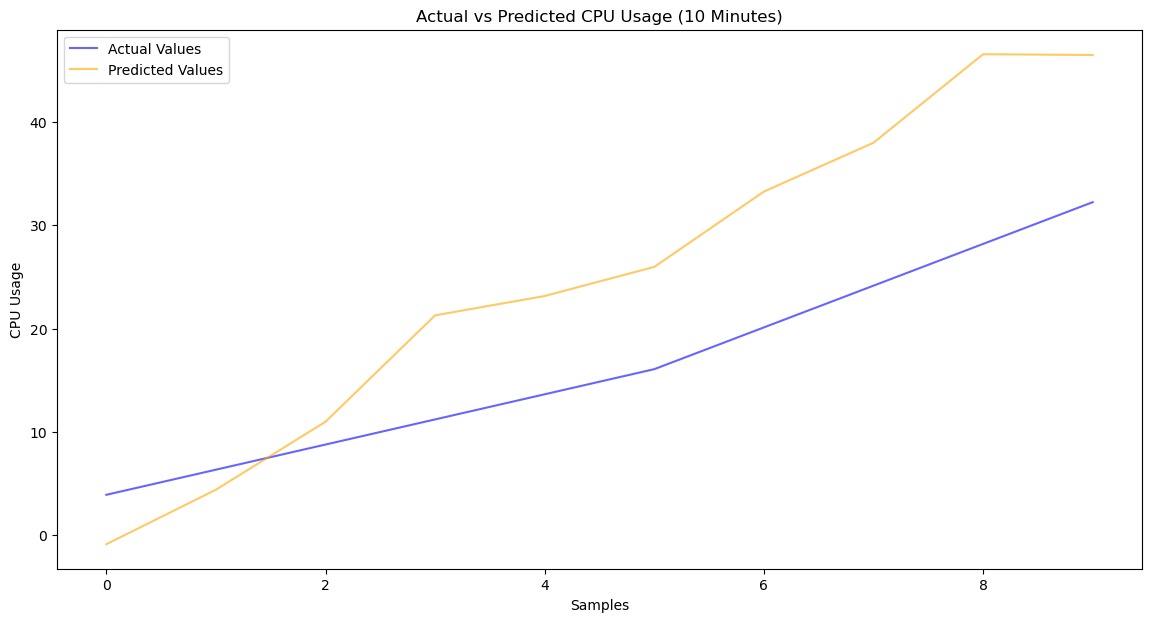

RMSE: 23.52014449634646, MSE: 553.1971971290167


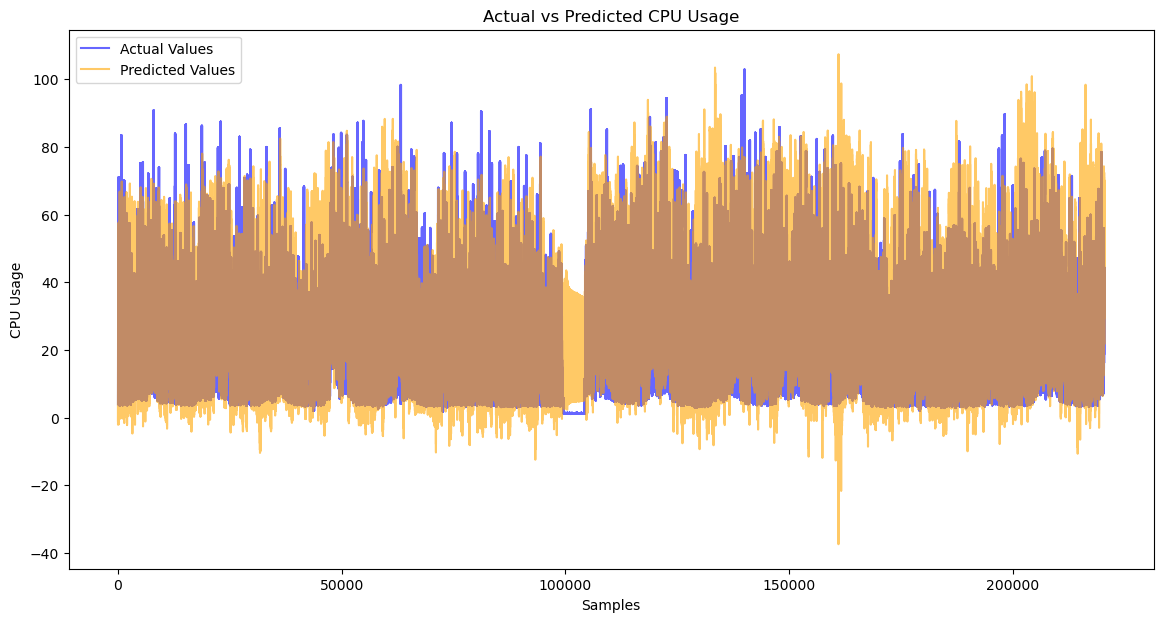

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

# Define a function to create lagged features
def create_additional_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df['cpu_change'] = df['cpu_usage'].diff() # Change in CPU usage
    df['moving_avg'] = df['cpu_usage'].rolling(window=10).mean() # 10-minute moving average
    return df

cpu_data = pd.read_csv('../Utilities\csv/cpu_usage_data_test.csv')
# Convert 'datetime' column to datetime objects
cpu_data['datetime'] = pd.to_datetime(cpu_data['datetime'])

# Set 'datetime' as the index
cpu_data.set_index('datetime', inplace=True)

# Resample to 1-minute intervals and interpolate
cpu_data = cpu_data.resample('1T').interpolate(method='linear')
cpu_data.reset_index(inplace=True)
if 'machine_id' in cpu_data.columns:
    cpu_data['machine_id'] = pd.Categorical(cpu_data['machine_id']).codes + 1
else:
    cpu_data['machine_id'] = 1
cpu_data = create_time_features(cpu_data)
lags = [5, 10, 60]
cpu_data = create_additional_features(cpu_data, 'cpu_usage', lags)

# Drop any rows with NaN values that were created due to shifting
cpu_data.dropna(inplace=True)

column_to_move = cpu_data.pop('cpu_usage')
cpu_data.insert(1, 'cpu_usage', column_to_move)
all_features_no_timestamp = cpu_data.columns[1:len(cpu_data.columns)]
# Extract the relevant features from your dataset for the HMM
features_for_hmm = cpu_data[all_features_no_timestamp].values

# Define and fit the HMM model
num_states = 2  # You can adjust this based on the nature of the data
model = hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=1000)

# Fit the HMM model to the features
model.fit(features_for_hmm)

# Predict hidden states for each time step
hidden_states = model.predict(features_for_hmm)

cpu_data['hidden_state'] = hidden_states

cpu_data.head

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Window size (e.g., past 60 time steps) and prediction horizon (next 10 timesteps)
window_size = 60
prediction_horizon = 10

# Function to generate LSTM sequences
def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
# Scale features and target (fit on the entire dataset)
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage])
cpu_data[["cpu_usage"]] = target_scaler.fit_transform(cpu_data[["cpu_usage"]])

X_test, y_test = create_lstm_sequences(cpu_data, window_size, prediction_horizon)

# Print the shapes of the final train/test data
print("Train shapes:", X_test.shape)
print("Test shapes:", y_test.shape)

lstm_model = load_model('best_model_test.hdf5')

# Make predictions
y_pred = lstm_model.predict(X_test)

# Inverse transform the predictions using the target scaler
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# If `y_test` also needs inverse transforming
y_test_unscaled = target_scaler.inverse_transform(y_test)


# Calculate MSE and RMSE
mse_lstm = mean_squared_error(y_test_unscaled[0], y_pred_unscaled[0])
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

# Plotting Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled[0], label='Actual Values', color='blue', alpha=0.6)
plt.plot(y_pred_unscaled[0], label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage (10 Minutes)')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

mse_lstm = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")
# Plotting Actual vs Predicted values
y_test_rescaled_flat = y_test_unscaled.flatten()
predictions_rescaled_flat = y_pred_unscaled.flatten()
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()